In [2]:
%matplotlib inline

In [3]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as pltcol

plt.style.use("project_style.mplstyle")

from models import RNNGC
from plotting_functions import multiimshow
from dataset import DatasetMaker
from tqdm import tqdm
import spatial_maps as sm

In [4]:
model = RNNGC()
model = model.load("./saved-models/RNNGC_49999.pkl")

In [5]:
# create data
res = 32
timesteps = 10
dataset = DatasetMaker()
rt, vt = dataset.generate_data(10000, timesteps)
inputs = (rt[:,0], vt)

In [6]:
# create "labels": run model without pruning
label_g = model(inputs).detach().numpy() # double check that states are alright
ratemaps = scipy.stats.binned_statistic_2d(rt[...,0].ravel().numpy(), rt[...,1].ravel().numpy(), label_g.reshape(-1, label_g.shape[-1]).T, bins = res)[0]

In [7]:
grid_scores = np.array([sm.gridness(ratemaps[i]) for i in range(len(ratemaps))])

cutoff = 0.15
low_gs_mask  = grid_scores < cutoff
high_gs_mask = grid_scores > cutoff

print(f"Cutoff: {cutoff}, number below: {low_gs_mask.sum()}")

Cutoff: 0.15, number below: 29


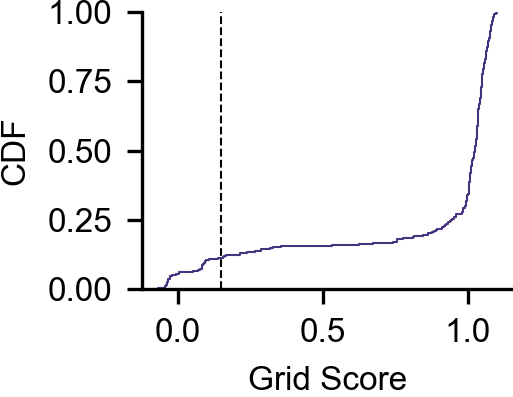

In [12]:
plt.figure()
plt.ecdf(grid_scores, linewidth = 0.5)
plt.vlines(cutoff, 0, 1, "k", linestyles="dashed", linewidth = 0.5)
plt.xlabel("Grid Score")
plt.ylabel("CDF")
plt.savefig("./figures/gs_ecdf")

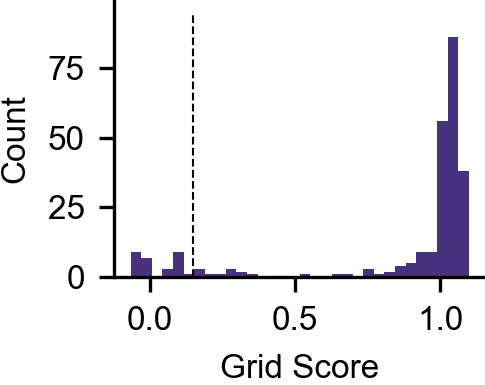

In [10]:
count, a, b = plt.hist(grid_scores, bins = 32);
plt.vlines(cutoff, 0, np.amax(count)*1.1, "k", linestyles="dashed", linewidth = 0.5)
plt.xlabel("Grid Score")
plt.ylabel("Count")
plt.savefig("./figures/rnn_grid_score_cutoff")

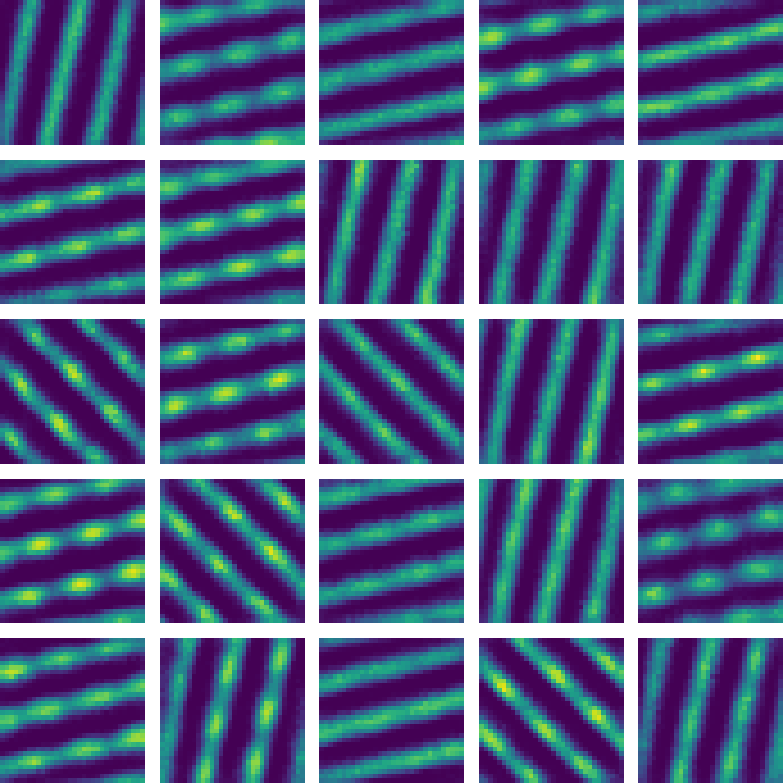

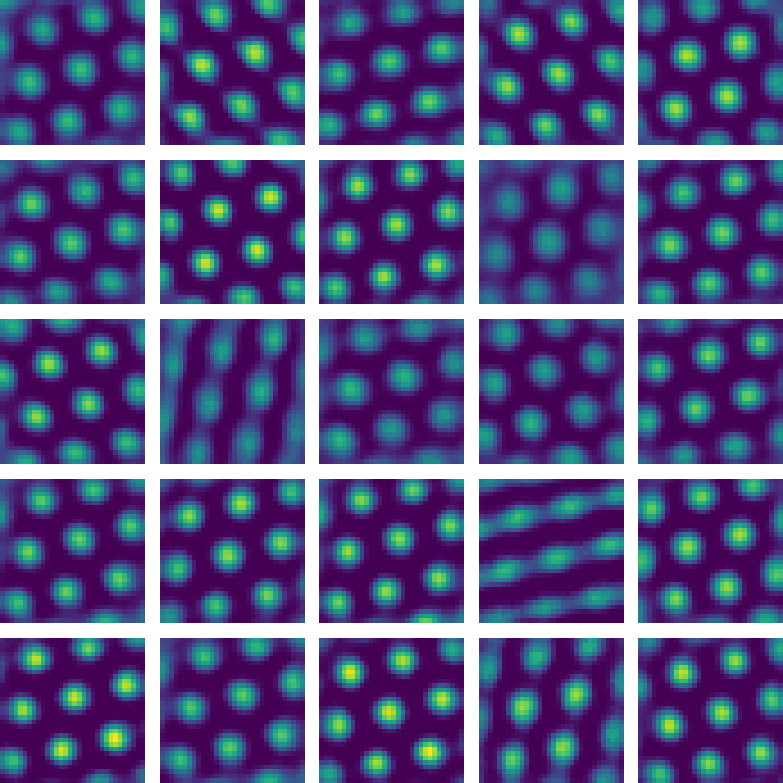

In [9]:
multiimshow(ratemaps[low_gs_mask][:25], figsize=(3,3), add_colorbar=False);
plt.savefig(f"./figures/ratemaps_gs_below_cutoff")
multiimshow(ratemaps[high_gs_mask][:25], figsize = (3,3), add_colorbar = False);
plt.savefig(f"./figures/ratemaps_gs_above_cutoff")

In [10]:
norm = pltcol.Normalize(vmin = np.amin(grid_scores), vmax = np.amax(grid_scores))
cmap = cm.viridis
grid_score_mappable = cm.ScalarMappable(norm, cmap)

def get_color(values):
    cmap = cm.viridis
    val = norm(np.mean(values))
    color = cmap(val)
    return color

In [11]:
# set indices
high_gc_inds = np.arange(model.ng)[high_gs_mask] # select indices of high GS units
all_inds = np.arange(model.ng) # all_inds :)

In [12]:
# prune low GS units
low_gs_color = get_color(grid_scores[low_gs_mask])
low_gs_prune_v = model.prune_forward(inputs, v_mask = torch.tensor(~low_gs_mask))
low_gs_error = torch.mean(torch.sum((torch.tensor(label_g) - low_gs_prune_v)**2, axis = -1), axis = 0)

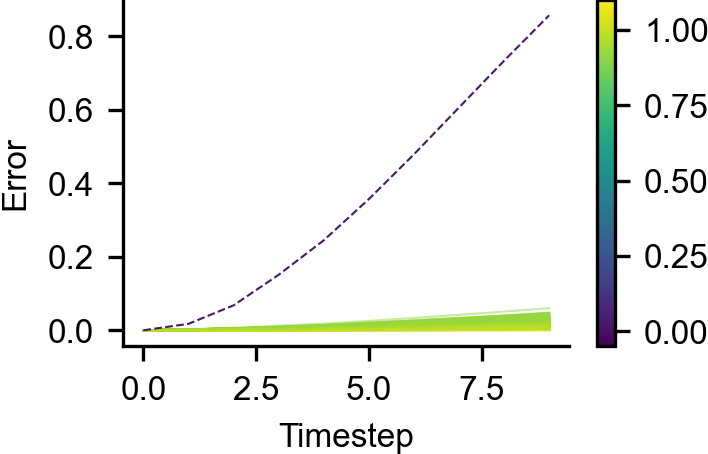

In [13]:
# prune only high GS units
plt.figure(figsize=(2.4,1.5))
for i in range(1000):
    prune_mask = np.ones(model.ng).astype("float32") # prune none
    prune_inds = np.random.choice(high_gc_inds, size = low_gs_mask.sum(), replace = False)
    # Select randomly among high-GS units, number equal to non-grid units
    prune_mask[prune_inds] = 0
    # prune velocity input to selected cells
    g_prune_v = model.prune_forward(inputs, v_mask = torch.tensor(prune_mask))
    error = torch.mean(torch.sum((torch.tensor(label_g) - g_prune_v)**2, axis = -1), axis = 0)

    color = get_color(grid_scores[prune_inds])
    plt.plot(error.detach().numpy(), color = color, linewidth = 0.5, alpha = 0.5)

plt.plot(low_gs_error.detach().numpy(), "--", color = low_gs_color, linewidth = 0.5)
plt.colorbar(grid_score_mappable, ax = plt.gca())
plt.xlabel("Timestep")
plt.ylabel("Error")
plt.savefig("./figures/prune_high_gs")

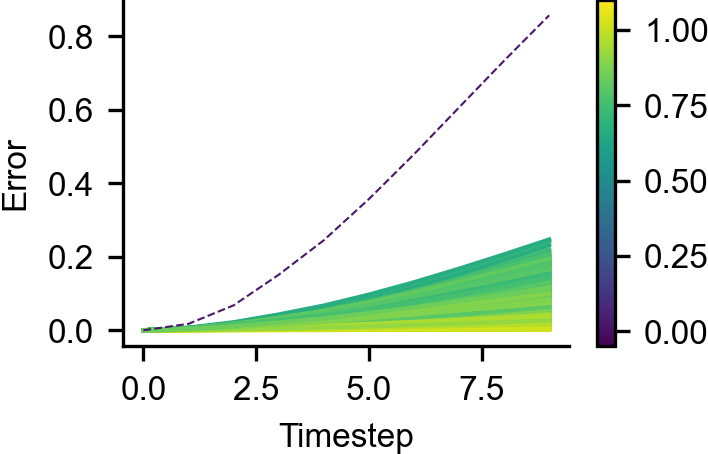

In [14]:
errors = []
mean_scores = []
plt.figure(figsize=(2.4,1.5))

# Prune random selection (including low GS units)
for i in range(1000):
    # select randomly from all units
    prune_mask = np.ones(model.ng).astype("float32")
    prune_inds = np.random.choice(all_inds, size = low_gs_mask.sum(), replace = False)
    prune_mask[prune_inds] = 0
    g_prune_v = model.prune_forward(inputs, v_mask = torch.tensor(prune_mask))
    error = torch.mean(torch.sum((torch.tensor(label_g) - g_prune_v)**2, axis = -1), axis = 0)
    # plot color as function of grid score in selection
    color = get_color(grid_scores[prune_inds])
    plt.plot(error.detach().numpy(), color = color)
    errors.append(error.detach().numpy())
    mean_scores.append(np.mean(grid_scores[prune_inds]))

plt.plot(low_gs_error.detach().numpy(), "--", color = low_gs_color, linewidth = 0.5)
plt.colorbar(grid_score_mappable, ax = plt.gca())
plt.xlabel("Timestep")
plt.ylabel("Error")
plt.savefig("./figures/prune_all")

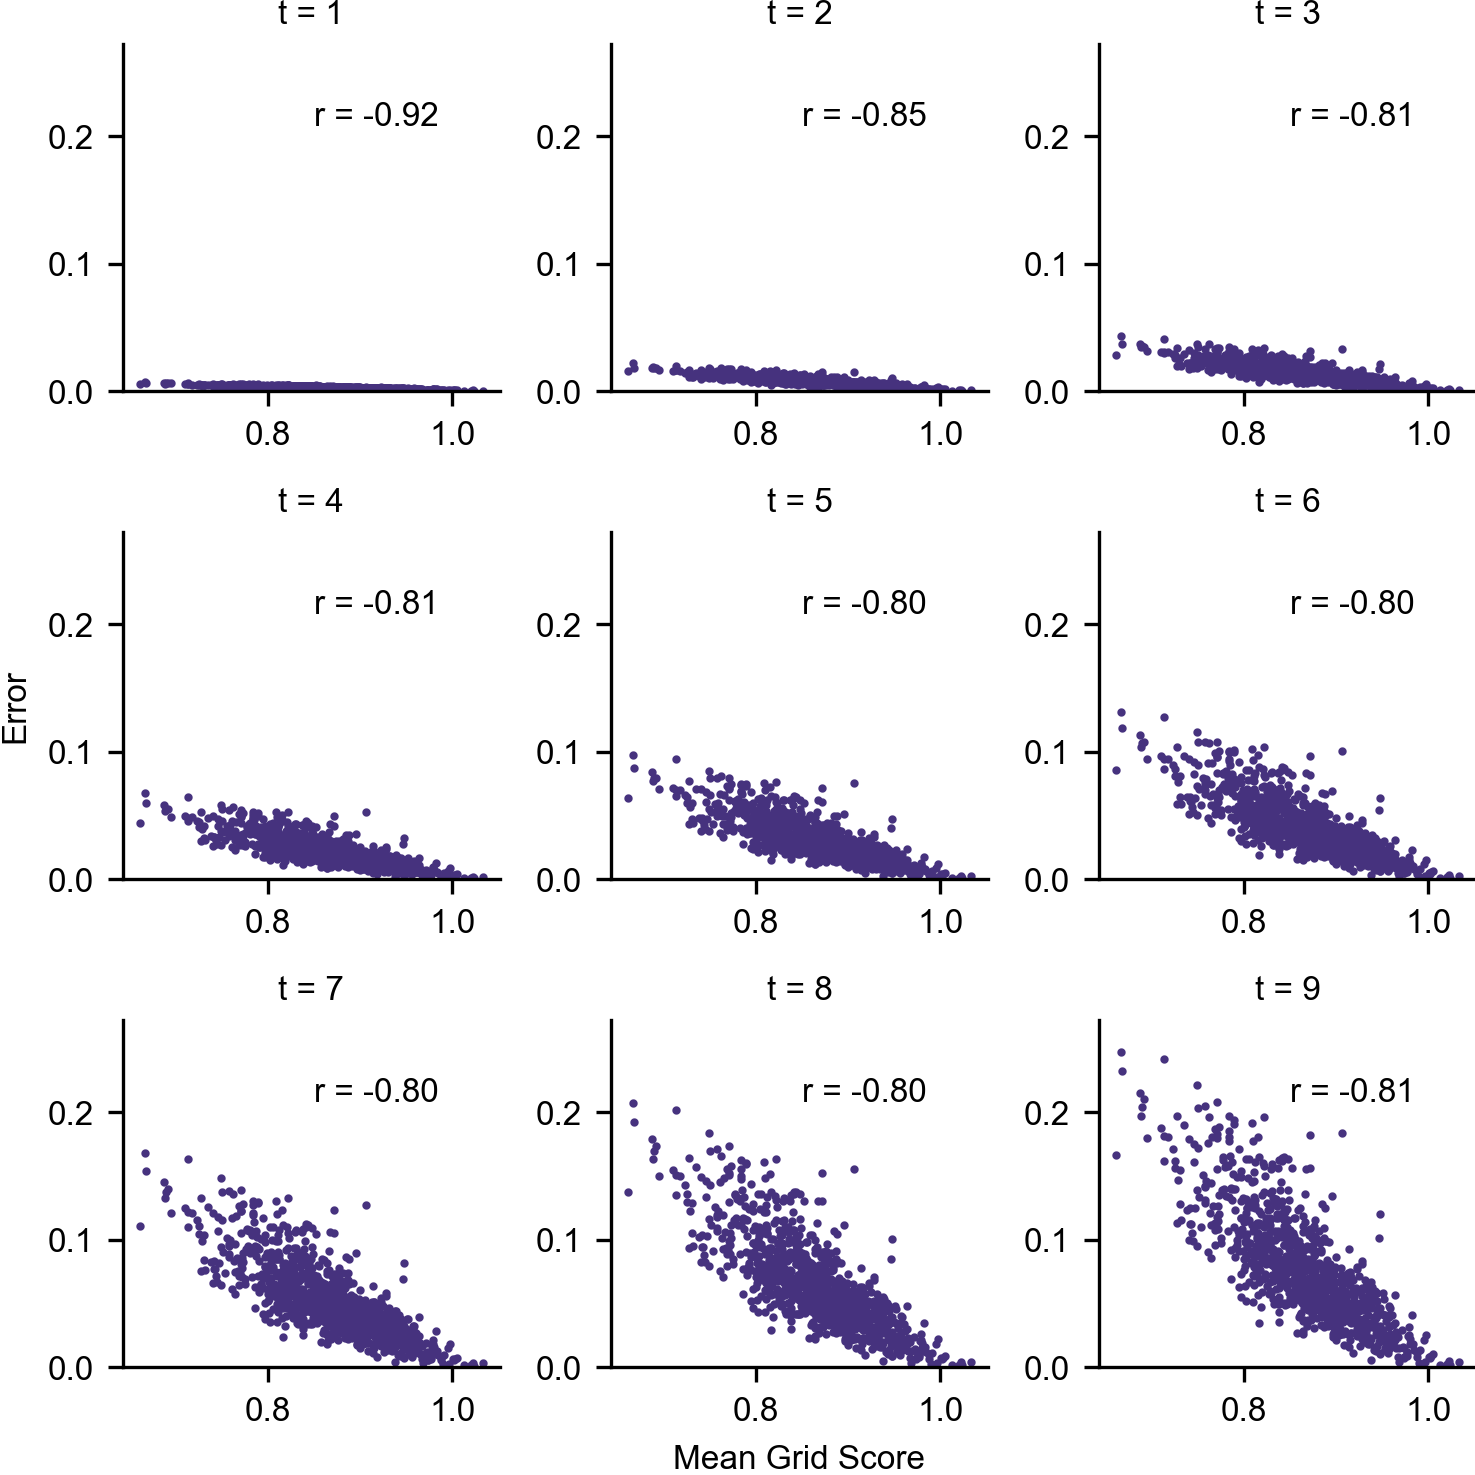

In [15]:
errors = np.array(errors)
mean_scores = np.array(mean_scores)

tx = 0.85
ty = 0.18

fig, ax = plt.subplots(3, 3, figsize = (5, 5))
for i in range(1, errors.shape[-1]):
    coeff = scipy.stats.linregress(mean_scores, errors[:,i]).rvalue
    ax.ravel()[i-1].text(tx, ty, f"r = {coeff:.2f}\n ")
    ax.ravel()[i-1].scatter(mean_scores, errors[:,i])
    ax.ravel()[i-1].set_ylim([0, np.amax(errors)*1.1])
    ax.ravel()[i-1].set_title(f"t = {i}")

plt.tight_layout()
ax[-1,1].set_xlabel("Mean Grid Score")
ax[1,0].set_ylabel("Error")
plt.savefig("./figures/prune_rnn_correlation")

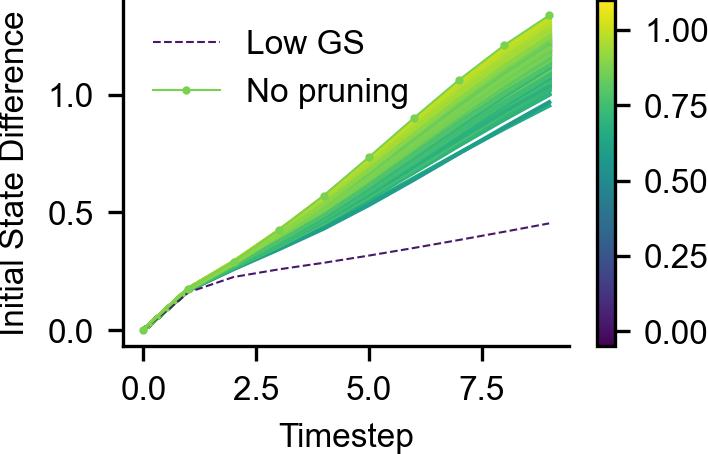

In [16]:
# add baselines; one for no pruning relative to t = 0, one relative to standing still
plt.figure(figsize=(2.4,1.5))
for i in range(1000):
    # select from all units
    prune_mask = np.ones(model.ng).astype("float32")
    prune_inds = np.random.choice(np.arange(model.ng), size = low_gs_mask.sum(), replace = False)
    prune_mask[prune_inds] = 0
    g_prune_v = model.prune_forward(inputs, v_mask = torch.tensor(prune_mask))
    error = torch.mean(torch.sum((torch.tensor(label_g[:,0,None]) - g_prune_v)**2, axis = -1), axis = 0)
    
    color = get_color(grid_scores[prune_inds])
    plt.plot(error.detach().numpy(), color = color)

init_state_error = torch.mean(torch.sum((torch.tensor(label_g[:,0,None]) - low_gs_prune_v)**2, axis = -1), axis = 0)

plt.plot(init_state_error.detach().numpy(), "--", linewidth = 0.5, label = "Low GS", color = low_gs_color)
plt.plot(np.mean(np.sum((label_g - label_g[:,0, None])**2, axis= -1) ,axis=0), "o-", linewidth = 0.5, label = "No pruning", color = get_color(grid_scores))
plt.colorbar(grid_score_mappable, ax = plt.gca())
plt.xlabel("Timestep")
plt.ylabel("Initial State Difference")
plt.legend()
plt.savefig("./figures/prune_baseline")
plt.show()